<a href="https://colab.research.google.com/github/jeremiegautreau/Tweet_classification_bert/blob/main/Project_tweet_classification_Bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project : Tweets classification of French presidential candidates**

### **LLM fine tuning**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Libraries installation**

In [ ]:
!pip install sentencepiece

In [ ]:
!pip install transformers

In [ ]:
!pip install emoji

In [ ]:
!pip install imblearn

**Importing libraries**

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import sys
import emoji
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from imblearn.over_sampling import RandomOverSampler
from transformers import CamembertForSequenceClassification, CamembertTokenizer, AdamW
from tqdm import trange
import random

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report

**Importing data**

In [ ]:
data_c2 = pd.read_csv('/content/drive/MyDrive/projet_tweet_Bert.csv', sep=';')
data_c2.head()

,id,created_at,text,label,lang,score
0,1462180440425607169,2021-11-20 22:05:57+00:00,Deux victoires des Bleus aujourd’hui en rugby ...,Emmanuel Macron,fr,0.999997
1,1461778741395443717,2021-11-19 19:29:45+00:00,Je ne lâcherai jamais nos pêcheurs. https://t....,Emmanuel Macron,fr,0.857141
2,1461775878170550272,2021-11-19 19:18:22+00:00,"Investir dans l’éducation, la santé, la cultur...",Emmanuel Macron,fr,0.999997
3,1461404337394130949,2021-11-18 18:42:00+00:00,Faire France ! https://t.co/9WcHqxc2E7,Emmanuel Macron,fr,0.999994
4,1461399807432474629,2021-11-18 18:24:00+00:00,"Nous allons continuer de faire.\nAvec vous, Ma...",Emmanuel Macron,fr,0.999997


**Preprocessing des tweets**

In [ ]:
def preprocessing_camenBert(texte):
    texte = texte.replace('\n', " ")
    texte = texte.replace('’', "'")
    texte = emoji.demojize(texte)
    texte = re.sub(r"https?:[^\s]+", "", texte)
    return texte

In [ ]:
data_c2['Bert'] = data_c2['text'].apply(preprocessing_camenBert)

**Analyse de la target**

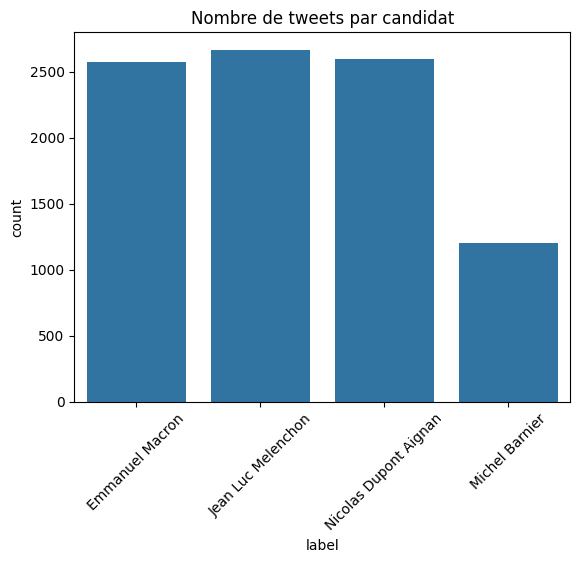

In [ ]:
import seaborn as sns

sns.countplot(x='label', data=data_c2)
plt.xticks(rotation=45)
plt.title('Nombre de tweets par candidat')
plt.show()


**Encodage de la target**

In [ ]:
la_enc = LabelEncoder()

data_c2['label_enc']= la_enc.fit_transform(data_c2['label'].values)

**Tokenizer**

In [ ]:
Tokenizer = CamembertTokenizer.from_pretrained(
    'camembert-base',
    do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/508 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
def tokenize_camenbert(data, Tokenizer, batch):
  encoded_batch = Tokenizer.batch_encode_plus(data['Bert'],
                                            add_special_tokens=True,
                                            #max_length=MAX_LENGTH,
                                            padding=True,
                                            truncation=True,
                                            return_attention_mask = True,
                                            return_tensors = 'pt')

  labels = data['label_enc'].values.tolist()
  labels = torch.tensor(labels)

  dataset = TensorDataset(
    encoded_batch['input_ids'],
    encoded_batch['attention_mask'],
    labels)

  batch_size = batch

  dataloader = DataLoader(
            dataset,
            sampler = RandomSampler(dataset),
            batch_size = batch_size)

  return dataloader


**Train test split**

In [ ]:
train, val_test = train_test_split(
    data_c2[['Bert', 'label_enc']],
    test_size = 0.2,
    shuffle = True,
    stratify = data_c2['label_enc'])

In [ ]:
validation, test = train_test_split(
    val_test[['Bert', 'label_enc']],
    test_size = 0.2,
    shuffle = True,
    stratify = val_test['label_enc'])

**Dealing with imbalanced dataset**

In [ ]:
ros = RandomOverSampler(sampling_strategy='minority',random_state=0)
X_res, y_res = ros.fit_resample(train, train['label_enc'])

**Preparing data for the model**

In [ ]:
batch_size = 32

In [ ]:
train_dataloader = tokenize_camenbert(X_res, Tokenizer, batch_size)

In [ ]:
validation_dataloader = tokenize_camenbert(val_test, Tokenizer, batch_size)

In [ ]:
test_dataloader = tokenize_camenbert(test, Tokenizer, batch_size)

**Loading pretrained model for fine tuning**

In [ ]:
model = CamembertForSequenceClassification.from_pretrained(
    'camembert-base',
    num_labels = 4 # number of class
    )

model.safetensors:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at camembert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


**Fine tuning for the task of tweets classification**

In [ ]:
# function for calculation of metrics
def b_tp(preds, labels):
  return sum([preds == labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_fp(preds, labels):
  return sum([preds != labels and preds == 1 for preds, labels in zip(preds, labels)])

def b_tn(preds, labels):
  return sum([preds == labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_fn(preds, labels):
  return sum([preds != labels and preds == 0 for preds, labels in zip(preds, labels)])

def b_metrics(preds, labels):

  preds = np.argmax(preds, axis = 1).flatten()
  labels = labels.flatten()
  tp = b_tp(preds, labels)
  tn = b_tn(preds, labels)
  fp = b_fp(preds, labels)
  fn = b_fn(preds, labels)
  b_precision = tp / (tp + fp) if (tp + fp) > 0 else 'nan'
  b_recall = tp / (tp + fn) if (tp + fn) > 0 else 'nan'
  b_specificity = tn / (tn + fp) if (tn + fp) > 0 else 'nan'
  b_f1_score = f1_score(labels, preds, average = 'weighted')
  return b_precision, b_recall, b_specificity, b_f1_score

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),
                  lr = 3e-5, # Learning Rate
                  eps = 1e-8) # Epsilon

scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,factor=0.5, mode='min',patience=2, verbose=True)

epochs = 12

In [ ]:
model.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Training loop

initial_lr = optimizer.param_groups[0]['lr']

for _ in trange(epochs, desc = 'Epoch'):


    model.train()


    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        model.zero_grad()
        # Forward pass
        train_output = model(b_input_ids,
                             token_type_ids = None,
                             attention_mask = b_input_mask,
                             labels = b_labels)
        # Backward pass
        train_output.loss.backward()
        optimizer.step()

        tr_loss += train_output.loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    model.eval()


    val_accuracy = []
    val_precision = []
    val_recall = []
    val_specificity = []
    val_f1_score = []

    val_loss = 0
    nb_val_examples, nb_val_steps = 0, 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        with torch.no_grad():
          # Forward pass
          eval_output = model(b_input_ids,
                              token_type_ids = None,
                              attention_mask = b_input_mask)

        logits_val = eval_output.logits
        logits = eval_output.logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        loss_fn = torch.nn.CrossEntropyLoss()
        loss = loss_fn(logits_val, b_labels)
        val_loss += loss.item()

        nb_val_examples += b_input_ids.size(0)
        nb_val_steps += 1


        avg_val_loss = val_loss / nb_val_steps

        new_lr = optimizer.param_groups[0]['lr']
        if new_lr != initial_lr:
          print(f"Learning rate reduced from {initial_lr:.6f} to {new_lr:.6f}")
          initial_lr = new_lr

        # calculation of metrics
        b_precision, b_recall, b_specificity, b_f1_score = b_metrics(logits, label_ids)

        if b_precision != 'nan': val_precision.append(b_precision)

        if b_recall != 'nan': val_recall.append(b_recall)

        if b_specificity != 'nan': val_specificity.append(b_specificity)

        if b_f1_score != 'nan': val_f1_score.append(b_f1_score)

    print('\n\t - Train loss: {:.4f}'.format(tr_loss / nb_tr_steps))
    print('\t - Val loss: {:.4f}'.format(avg_val_loss))
    print('\t - Validation Precision: {:.4f}'.format(sum(val_precision)/len(val_precision)) if len(val_precision)>0 else '\t - Validation Precision: NaN')
    print('\t - Validation Recall: {:.4f}'.format(sum(val_recall)/len(val_recall)) if len(val_recall)>0 else '\t - Validation Recall: NaN')
    print('\t - Validation Specificity: {:.4f}'.format(sum(val_specificity)/len(val_specificity)) if len(val_specificity)>0 else '\t - Validation Specificity: NaN')
    print('\t - Validation F1_score: {:.4f}\n'.format(sum(val_f1_score)/len(val_f1_score)) if len(val_f1_score)>0 else '\t - Validation F1-score: NaN')

    scheduler.step(avg_val_loss)

Epoch:   8%|▊         | 1/12 [01:26<15:52, 86.61s/it]


	 - Train loss: 0.7899
	 - Val loss: 0.5203
	 - Validation Precision: 0.7728
	 - Validation Recall: 0.7728
	 - Validation Specificity: 0.7858
	 - Validation F1_score: 0.8140



Epoch:  17%|█▋        | 2/12 [02:52<14:24, 86.45s/it]


	 - Train loss: 0.3250
	 - Val loss: 0.4134
	 - Validation Precision: 0.8482
	 - Validation Recall: 0.8737
	 - Validation Specificity: 0.8396
	 - Validation F1_score: 0.8546



Epoch:  25%|██▌       | 3/12 [04:19<12:57, 86.36s/it]


	 - Train loss: 0.1649
	 - Val loss: 0.4373
	 - Validation Precision: 0.8785
	 - Validation Recall: 0.8167
	 - Validation Specificity: 0.8837
	 - Validation F1_score: 0.8629



Epoch:  33%|███▎      | 4/12 [05:45<11:31, 86.40s/it]


	 - Train loss: 0.0918
	 - Val loss: 0.4569
	 - Validation Precision: 0.8612
	 - Validation Recall: 0.8407
	 - Validation Specificity: 0.8627
	 - Validation F1_score: 0.8671



Epoch:  42%|████▏     | 5/12 [07:12<10:05, 86.47s/it]


	 - Train loss: 0.0538
	 - Val loss: 0.5812
	 - Validation Precision: 0.8888
	 - Validation Recall: 0.7825
	 - Validation Specificity: 0.8920
	 - Validation F1_score: 0.8575

Learning rate reduced from 0.000030 to 0.000015


Epoch:  50%|█████     | 6/12 [08:38<08:38, 86.49s/it]


	 - Train loss: 0.0331
	 - Val loss: 0.5418
	 - Validation Precision: 0.9175
	 - Validation Recall: 0.8126
	 - Validation Specificity: 0.9240
	 - Validation F1_score: 0.8681



Epoch:  58%|█████▊    | 7/12 [10:05<07:12, 86.51s/it]


	 - Train loss: 0.0273
	 - Val loss: 0.5583
	 - Validation Precision: 0.9010
	 - Validation Recall: 0.8105
	 - Validation Specificity: 0.9121
	 - Validation F1_score: 0.8664



Epoch:  67%|██████▋   | 8/12 [11:31<05:46, 86.53s/it]


	 - Train loss: 0.0162
	 - Val loss: 0.5726
	 - Validation Precision: 0.8858
	 - Validation Recall: 0.8394
	 - Validation Specificity: 0.8945
	 - Validation F1_score: 0.8764

Learning rate reduced from 0.000015 to 0.000008


Epoch:  75%|███████▌  | 9/12 [12:58<04:20, 86.68s/it]


	 - Train loss: 0.0095
	 - Val loss: 0.6604
	 - Validation Precision: 0.9159
	 - Validation Recall: 0.7833
	 - Validation Specificity: 0.9198
	 - Validation F1_score: 0.8655



Epoch:  83%|████████▎ | 10/12 [14:26<02:53, 86.83s/it]


	 - Train loss: 0.0079
	 - Val loss: 0.5980
	 - Validation Precision: 0.9144
	 - Validation Recall: 0.8260
	 - Validation Specificity: 0.9152
	 - Validation F1_score: 0.8746



Epoch:  92%|█████████▏| 11/12 [15:53<01:26, 86.87s/it]


	 - Train loss: 0.0085
	 - Val loss: 0.5983
	 - Validation Precision: 0.9171
	 - Validation Recall: 0.8370
	 - Validation Specificity: 0.9120
	 - Validation F1_score: 0.8777

Learning rate reduced from 0.000008 to 0.000004


Epoch: 100%|██████████| 12/12 [17:19<00:00, 86.63s/it]


	 - Train loss: 0.0053
	 - Val loss: 0.6201
	 - Validation Precision: 0.8960
	 - Validation Recall: 0.8319
	 - Validation Specificity: 0.9013
	 - Validation F1_score: 0.8730



In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/presidential_tweets_.pt")

**Test**

In [ ]:
def predict(data, model=model):
  with torch.no_grad():
    model.eval()
    retour = model(data.input_ids.to(device), token_type_ids = None, attention_mask=data.attention_mask.to(device))

    return torch.argmax(retour[0], dim=1)

In [ ]:
test_enc = Tokenizer.batch_encode_plus(test['Bert'],
                                            add_special_tokens=True,
                                            #max_length=MAX_LENGTH,
                                            padding=True,
                                            truncation=True,
                                            return_attention_mask = True,
                                            return_tensors = 'pt')

In [ ]:
predictions = predict(test_enc, model=model)

In [ ]:
label = ['Emmanuel Macron', 'Jean Luc Melenchon', 'Michel Barnier','Nicolas Dupont Aignan']

In [ ]:
print('F1:', f1_score(test['label_enc'], predictions.cpu().numpy(), average = 'weighted'))

F1: 0.8752645504469642


In [ ]:
print(classification_report(test['label_enc'], predictions.cpu().numpy(), target_names=label))

                       precision    recall  f1-score   support

      Emmanuel Macron       0.83      0.94      0.88       103
   Jean Luc Melenchon       0.93      0.80      0.86       107
       Michel Barnier       0.92      0.94      0.93        48
Nicolas Dupont Aignan       0.86      0.86      0.86       104

             accuracy                           0.88       362
            macro avg       0.88      0.88      0.88       362
         weighted avg       0.88      0.88      0.88       362



**Confusion matrix**

In [ ]:
def display_conf_matrix(y_test, y_pred):
  fig, ax = plt.subplots(figsize=(10, 5))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
  ax.xaxis.set_ticklabels(label,rotation = 45)
  ax.yaxis.set_ticklabels(label)
  plt.show()

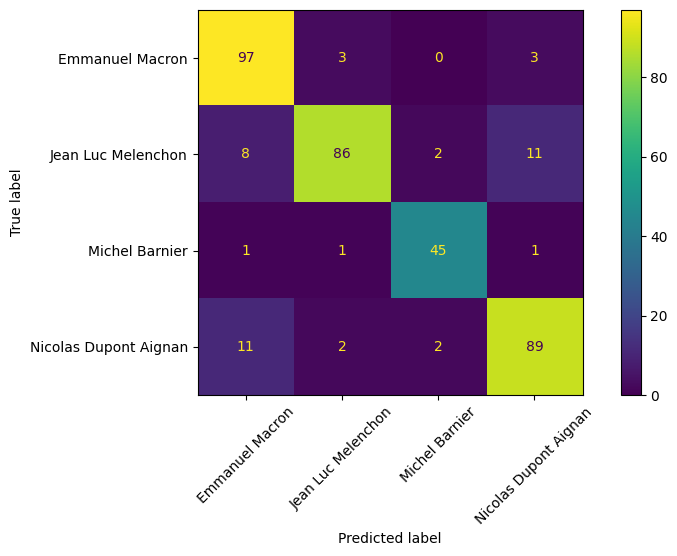

In [ ]:
display_conf_matrix(test['label_enc'].values, predictions.cpu().numpy())

**The fine tuning of the CamenBert model achieved a weighted F1 score of 0.87.  
We can see that there some errors between three candidates but overall the perfomance of the model is quite good.**